In [51]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import seaborn as sns



In [ ]:
# Load .mat file
file_path = r"C:\Users\user\Desktop\Brain Hackathon\stroke_rehab_data_analysis\data\P1_pre_training.mat"
data = loadmat(file_path)

# Extract data
fs = int(data['fs'][0][0])      # sampling frequency
trig = data['trig'].flatten()   # flatten from (N,1) → (N,)
y = data['y']                   # signal data (N,16)

# Create a time axis (in seconds)
time = np.arange(y.shape[0]) / fs

# Build dataframe: time, triggers, and all channels
columns = ['time_sec', 'trig'] + [f'ch{i+1}' for i in range(y.shape[1])]
df = pd.DataFrame(
    data = np.column_stack((time, trig, y)),
    columns = columns
)

# Save to CSV and Excel
# df.to_csv("stroke_data.csv", index=False)
# df.to_excel("stroke_data.xlsx", index=False)

print("✅ Data exported successfully")
print("Sampling frequency:", fs, "Hz")
print("Data shape:", df.shape)

✅ Data exported successfully
Sampling frequency: 256 Hz
Data shape: (271816, 18)


In [53]:
df.head()

,time_sec,trig,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,0.000000,0.0,38001.839844,36892.000000,46397.214844,50350.613281,37726.980469,57036.867188,46999.265625,47667.355469,47781.109375,39447.503906,49432.898438,48651.296875,49362.050781,47384.273438,38979.992188,61820.179688
1,0.003906,0.0,54828.550781,54868.156250,52444.156250,52408.507812,54521.210938,50932.191406,52738.488281,52781.171875,52272.847656,54376.527344,52604.574219,52560.785156,52507.796875,52978.863281,54474.457031,50255.472656
2,0.007812,0.0,-24629.253906,-24865.400391,-22964.140625,-22914.605469,-24873.259766,-22113.113281,-23516.539062,-23355.142578,-22624.406250,-24587.474609,-23058.496094,-23198.757812,-23129.423828,-23339.222656,-24563.939453,-21289.884766
3,0.011719,0.0,-77839.562500,-78191.210938,-76574.710938,-76846.210938,-78150.195312,-76362.351562,-77222.789062,-77171.906250,-76289.273438,-78103.726562,-77080.812500,-77045.546875,-76983.515625,-77237.015625,-77972.484375,-75860.140625
4,0.015625,0.0,-48999.753906,-49155.601562,-49435.792969,-49648.988281,-49283.152344,-50093.390625,-49608.496094,-49621.535156,-49217.925781,-49437.320312,-49688.796875,-50009.597656,-49660.007812,-49592.742188,-49244.277344,-50159.144531


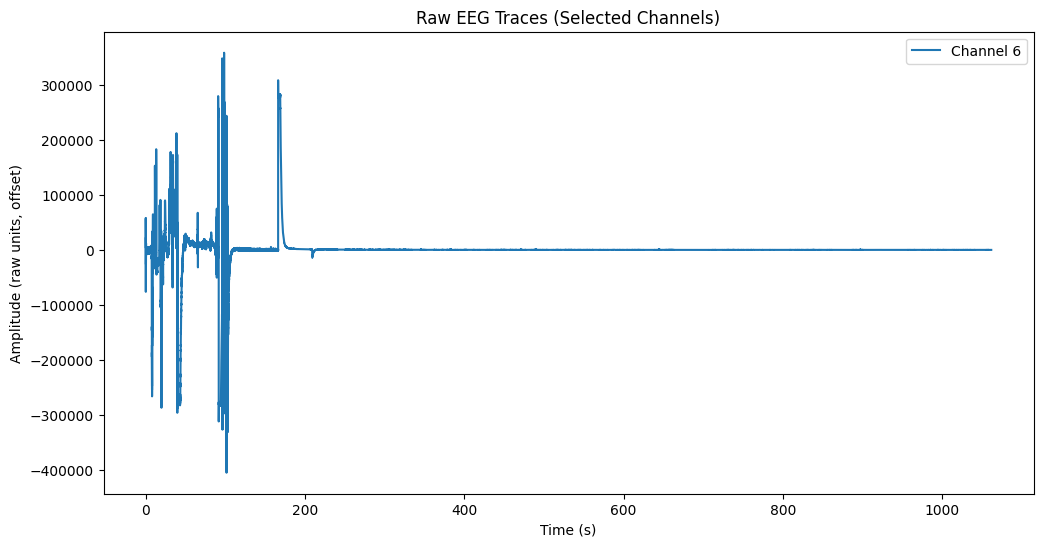

In [54]:

# First column = time, next columns = EEG channels
time = df.iloc[:, 0].values
eeg = df.iloc[:, 2:].values   # skipping col 1 if it's a trigger channel

# Choose some channels to plot (e.g., first 5 EEG channels)
channels_to_plot = [5]

offset = 50000 #vertical spacing between channels

plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels_to_plot):
    plt.plot(time, eeg[:, ch] + i*offset, label=f'Channel {ch+1}')
    # offset each channel vertically (50000 = shift, adjust based on your data scale)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (raw units, offset)")
plt.title("Raw EEG Traces (Selected Channels)")
plt.legend()
plt.show()


Left trials: (81920, 1280, 16)
Right trials: (80913, 1280, 16)


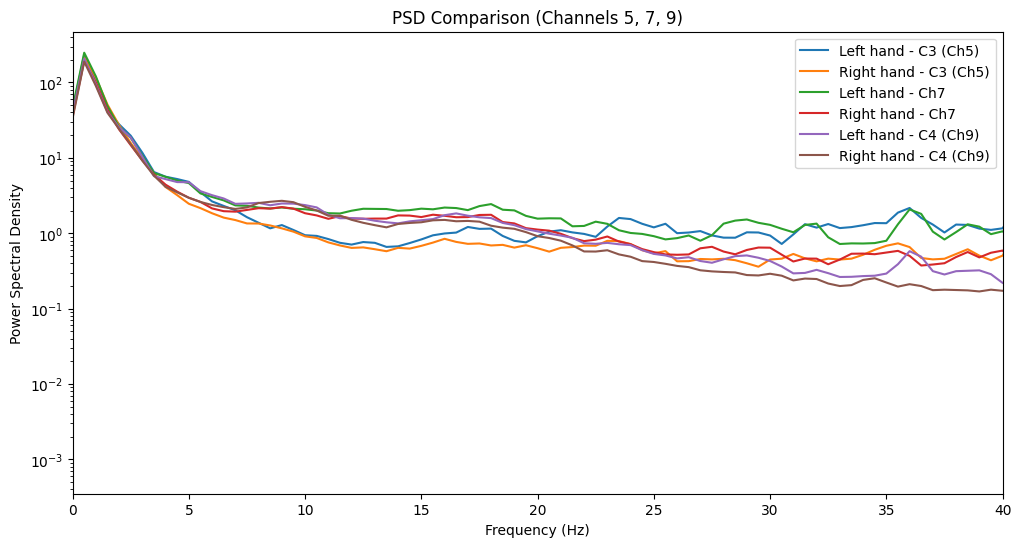

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ==== PARAMETERS ====
fs = 256                   # Sampling frequency
pre_time, post_time = 1, 4 # Epoch window: 1s before, 4s after trigger

# ==== LOAD DATA ====
time = df.iloc[:, 0].values
trigger = df.iloc[:, 1].values
eeg = df.iloc[:, 2:].values   # EEG channels only

# ==== EPOCH EXTRACTION ====
epoch_len = int((pre_time + post_time) * fs)
event_indices = np.where(trigger != 0)[0]

epochs_left, epochs_right = [], []

for idx in event_indices:
    label = trigger[idx]
    start = idx - int(pre_time * fs)
    end = idx + int(post_time * fs)
    if start < 0 or end > len(eeg):
        continue
    epoch = eeg[start:end, :]  # shape: (epoch_len, n_channels)
    if label == 1:   # left hand
        epochs_left.append(epoch)
    elif label == -1: # right hand
        epochs_right.append(epoch)

epochs_left = np.array(epochs_left)
epochs_right = np.array(epochs_right)

print("Left trials:", epochs_left.shape)
print("Right trials:", epochs_right.shape)

# ==== PSD FUNCTION ====
def compute_mean_psd(epochs, ch_idx, fs=256):
    psds = []
    for trial in epochs:
        f, Pxx = welch(trial[:, ch_idx], fs=fs, nperseg=fs*2)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

# ==== CHANNELS TO COMPARE ====
# Channel 5 → index 4, Channel 7 → index 6, Channel 9 → index 8
channels_to_compare = [4, 6, 8]
labels = ["C3 (Ch5)", "Ch7", "C4 (Ch9)"]

# ==== PLOTTING ====
plt.figure(figsize=(12, 6))

for ch_idx, label in zip(channels_to_compare, labels):
    f, psd_left = compute_mean_psd(epochs_left, ch_idx, fs)
    _, psd_right = compute_mean_psd(epochs_right, ch_idx, fs)

    plt.semilogy(f, psd_left, label=f"Left hand - {label}")
    plt.semilogy(f, psd_right, label=f"Right hand - {label}")

plt.xlim(0, 40)   # Focus on 0–40 Hz
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("PSD Comparison (Channels 5, 7, 9)")
plt.legend()
plt.show()


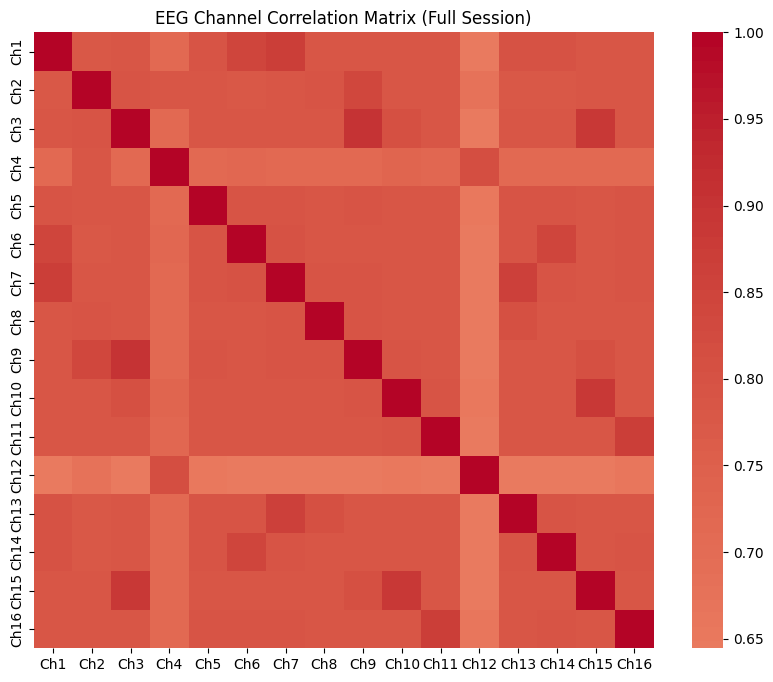

In [56]:
corr_matrix = np.corrcoef(eeg.T)  # correlation between channels

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0,
            xticklabels=[f"Ch{i+1}" for i in range(eeg.shape[1])],
            yticklabels=[f"Ch{i+1}" for i in range(eeg.shape[1])])
plt.title("EEG Channel Correlation Matrix (Full Session)")
plt.show()